In [62]:
import numpy as np
from inference.covid import covid as inference
import matplotlib.pyplot as plt
from rodeo.ibm import ibm_init
from rodeo.car import car_init
from rodeo.cython.KalmanODE import KalmanODE
from rodeo.utils import indep_init, zero_pad
from scipy.integrate import odeint
%load_ext Cython

def seirah(X_t, t, theta, x_out=None):
    "SEIRAH ODE function"
    if x_out is None:
        x_out = np.empty(6)
    p = len(X_t)//6
    S, E, I, R, A, H = X_t[::p]
    N = S + E + I + R + A + H
    b, r, alpha, D_e, D_I, D_q= theta
    D_h = 30
    x_out[0] = -b*S*(I + alpha*A)/N
    x_out[1] = b*S*(I + alpha*A)/N - E/D_e
    x_out[2] = r*E/D_e - I/D_q - I/D_I
    x_out[3] = (I + A)/D_I + H/D_h
    x_out[4] = (1-r)*E/D_e - A/D_I
    x_out[5] = I/D_q - H/D_h
    return x_out

def seirahpad(X_t, t, theta):
    x_der = np.empty(6)
    p = len(X_t)//6
    S, E, I, R, A, H = X_t[::p]
    N = S + E + I + R + A + H
    b, r, alpha, D_e, D_I, D_q = theta
    D_h = 30
    x_der[0] = -b*S*(I + alpha*A)/N
    x_der[1] = b*S*(I + alpha*A)/N - E/D_e
    x_der[2] = r*E/D_e - I/D_q - I/D_I
    x_der[3] = (I + A)/D_I + H/D_h
    x_der[4] = (1-r)*E/D_e - A/D_I
    x_der[5] = I/D_q - H/D_h
    return np.double(np.ravel([X_t[::p], x_der, np.zeros(6)], "F"))


In [2]:
n_deriv = [1]*6 # number of derivatives in IVP
n_deriv_prior = [3]*6 # number of derivatives in IBM prior
state_ind = [0, 3, 6, 9, 12, 15] # Index of 0th derivative of each state

# it is assumed that the solution is sought on the interval [tmin, tmax].
tmin = 0
tmax = 10

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
n_var = 6
sigma = [.5]*n_var

# Initial value, x0, for the IVP
theta_true = np.array([2.23, 0.034, 0.55, 5.1, 2.3, 0.36]) # True theta
x0 = np.array([63804435, 15492, 21752, 0, 618013, 93583])
v0 = seirah(x0, 0, theta_true)
X0 = np.ravel([x0, v0], 'F')
x0_state = zero_pad(X0, n_deriv, n_deriv_prior)

# W matrix: dimension is n_eq x sum(n_deriv)
W_mat = np.zeros((len(n_deriv), sum(n_deriv)+len(n_deriv)))
for i in range(len(n_deriv)): W_mat[i, sum(n_deriv[:i])+i+1] = 1
W = zero_pad(W_mat, n_deriv, n_deriv_prior)

n_eval = 50
dt = (tmax-tmin)/n_eval
ode_init= ibm_init(dt, n_deriv_prior, sigma)
kinit = indep_init(ode_init, n_deriv_prior)
kode = KalmanODE(W, tmin, tmax, n_eval, seirah, **kinit)

In [3]:
kode = KalmanODE(W, tmin, tmax, n_eval, seirah, **kinit)
ksim_ei = kode.solve_sim(x0_state, W, theta_true)

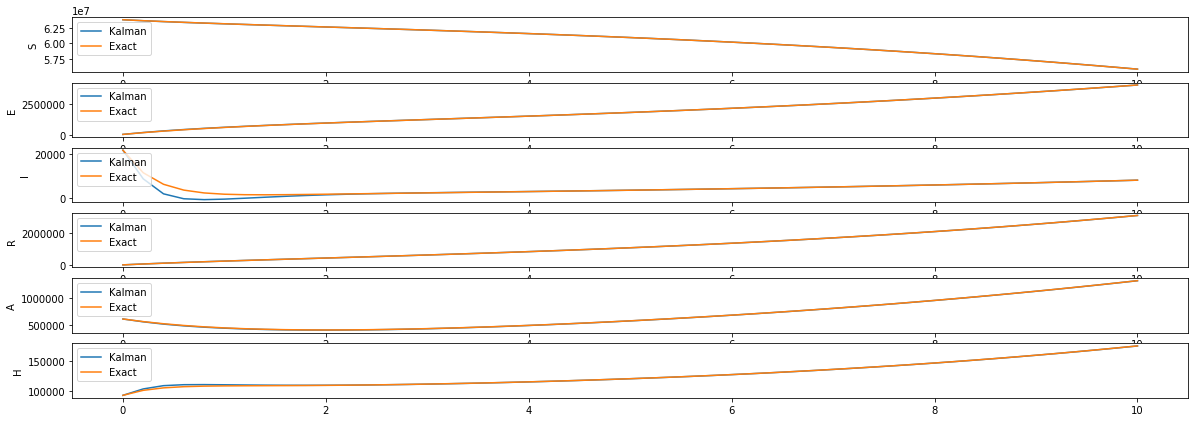

In [58]:
tseq = np.linspace(tmin, tmax, n_eval+1)
exact = odeint(seirah, x0, tseq, args=(theta_true,))

ylabel = ['S', 'E', 'I', 'R', 'A', 'H']
_, axs = plt.subplots(len(ylabel), 1, figsize=(20, 7))
for i in range(len(ylabel)):
    axs[i].plot(tseq, ksim_ei[:, n_deriv_prior[0]*i], label="Kalman")
    axs[i].set_ylabel(ylabel[i])
    axs[i].plot(tseq, exact[:, i], label='Exact')
    axs[i].legend(loc='upper left')

In [45]:
from timeit import default_timer as timer
from scipy.integrate import odeint
n_loops = 10
tseq = np.linspace(tmin, tmax, n_eval+1)
start = timer()
for i in range(n_loops):
    _ = odeint(seirah, x0, tseq, args=(theta_true, ))
end = timer()
(end - start)/n_loops

0.002036389999999955

In [58]:
n_loops=10
start = timer()
for i in range(n_loops):
    kode.solve_sim(x0_state, W, theta_true)
end = timer()
(end - start)/n_loops

0.004170750000000112

In [98]:
%%cython
import numpy as np

from numba import njit
@njit
def seirah2(X_t, t, theta, x_out=None):
    "SEIRAH ODE function"
    if x_out is None:
        x_out = np.empty(6)
    p = len(X_t)//6
    S, E, I, R, A, H = X_t[::p]
    N = S + E + I + R + A + H
    b, r, alpha, D_e, D_I, D_q= theta
    D_h = 30
    x_out[0] = -b*S*(I + alpha*A)/N
    x_out[1] = b*S*(I + alpha*A)/N - E/D_e
    x_out[2] = r*E/D_e - I/D_q - I/D_I
    x_out[3] = (I + A)/D_I + H/D_h
    x_out[4] = (1-r)*E/D_e - A/D_I
    x_out[5] = I/D_q - H/D_h
    return x_out

TypeError: The decorated object is not a function (got type <class 'builtin_function_or_method'>).

In [93]:
from numba import njit
@njit
def seirah2(X_t, t, theta, x_out=None):
    "SEIRAH ODE function"
    if x_out is None:
        x_out = np.empty(6)
    p = len(X_t)//6
    S, E, I, R, A, H = X_t[::p]
    N = S + E + I + R + A + H
    b, r, alpha, D_e, D_I, D_q= theta
    D_h = 30
    x_out[0] = -b*S*(I + alpha*A)/N
    x_out[1] = b*S*(I + alpha*A)/N - E/D_e
    x_out[2] = r*E/D_e - I/D_q - I/D_I
    x_out[3] = (I + A)/D_I + H/D_h
    x_out[4] = (1-r)*E/D_e - A/D_I
    x_out[5] = I/D_q - H/D_h
    return x_out

In [94]:
seirah2(x0_state, 0, theta_true, np.zeros(6))

array([-797144.23062465,  794106.58356583,  -69776.33352657,
        281278.12898551, -265766.937289  ,   57302.78888889])

In [97]:
%timeit -o seirah2(x0_state, 0, theta_true)

768 ns ± 44.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


<TimeitResult : 768 ns ± 44.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)>

In [87]:
%timeit -o seirah(x0_state, 0, theta_true)

6.02 µs ± 489 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


<TimeitResult : 6.02 µs ± 489 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)>

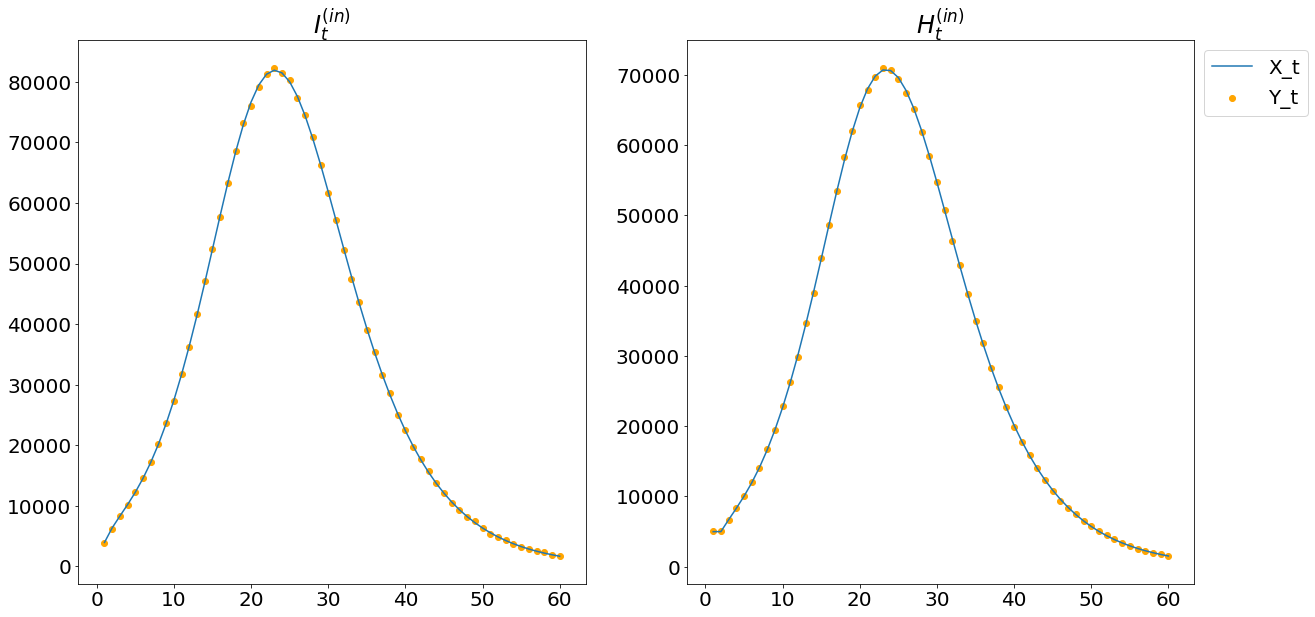

In [9]:
n_deriv = [1]*6 # number of derivatives in IVP
n_deriv_prior = [3]*6 # number of derivatives in IBM prior
state_ind = [0, 3, 6, 9, 12, 15] # Index of 0th derivative of each state

# it is assumed that the solution is sought on the interval [tmin, tmax].
tmin = 0
tmax = 60

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
n_var = 6
sigma = [.1]*n_var

# Initial value, x0, for the IVP
theta_true = np.array([2.23, 0.034, 0.55, 5.1, 2.3, 0.36]) # True theta
x0 = np.array([63804435, 15492, 21752, 0, 618013, 93583])

# W matrix: dimension is n_eq x sum(n_deriv)
W_mat = np.zeros((len(n_deriv), sum(n_deriv)+len(n_deriv)))
for i in range(len(n_deriv)): W_mat[i, sum(n_deriv[:i])+i+1] = 1
W = zero_pad(W_mat, n_deriv, n_deriv_prior)

# logprior parameters
n_theta = len(theta_true)

# Number of samples to draw from posterior
n_samples = 100000

# Initialize inference class and simulate observed data
inf = inference(state_ind, tmin, tmax, seirah, W)
inf.funpad = seirahpad
Y_t, X_t = inf.simulate(seirah, x0, theta_true)

# Plot observations and true value
tseq = np.linspace(tmin+1, tmax, tmax-tmin)
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].plot(tseq,  X_t[:,0], label = 'X_t')
axs[0].scatter(tseq, Y_t[:,0], label = 'Y_t', color='orange')
axs[0].set_title("$I^{(in)}_t$")
axs[1].plot(tseq, X_t[:,1], label = 'X_t')
axs[1].scatter(tseq, Y_t[:,1], label = 'Y_t', color='orange')
axs[1].set_title("$H^{(in)}_t$")
axs[1].legend(loc='upper left', bbox_to_anchor=[1, 1])

In [3]:
inf = inference(state_ind, tmin, tmax, seirah)
inf.funpad = seirahpad
hlst = np.array([.1])
dt = 1
theta_euler = np.zeros((len(hlst), n_samples, n_theta))
theta_kalman = np.zeros((len(hlst), n_samples, n_theta))
phi_init = np.append(np.log(theta_true), np.array([15492, 21752]))
#phi_init = np.log(theta_true)
phi_mean = np.zeros(n_theta)
phi_sd = np.log(10)*np.ones(n_theta)
xx0 = np.array([63804435, None, None, 0, 618013, 93583])

In [4]:
for i in range(len(hlst)):
    phi_hat, phi_var = inf.phi_fit(Y_t, xx0, hlst[i], dt, phi_mean, phi_sd, inf.euler_nlpost, 
                                   inf.euler_solve, inf.loglike_pois, phi_init=phi_init)
    theta_euler[i] = inf.theta_sample(phi_hat[:6], phi_var[:6, :6], n_samples)

In [6]:
for i in range(len(hlst)):
    ode_init= ibm_init(hlst[i], n_deriv_prior, sigma)
    kinit = indep_init(ode_init, n_deriv_prior)
    n_eval = int((tmax-tmin)/hlst[i])
    kode = KalmanODE(W, tmin, tmax, n_eval, seirah, **kinit)
    inf.kode = kode
    phi_hat, phi_var = inf.phi_fit(Y_t, xx0, hlst[i], dt, phi_mean, phi_sd, inf.kalman_nlpost, 
                                   inf.kalman_solve, inf.loglike_pois, phi_init=phi_init)
    theta_kalman[i] = inf.theta_sample(phi_hat[:6], phi_var[:6, :6], n_samples)

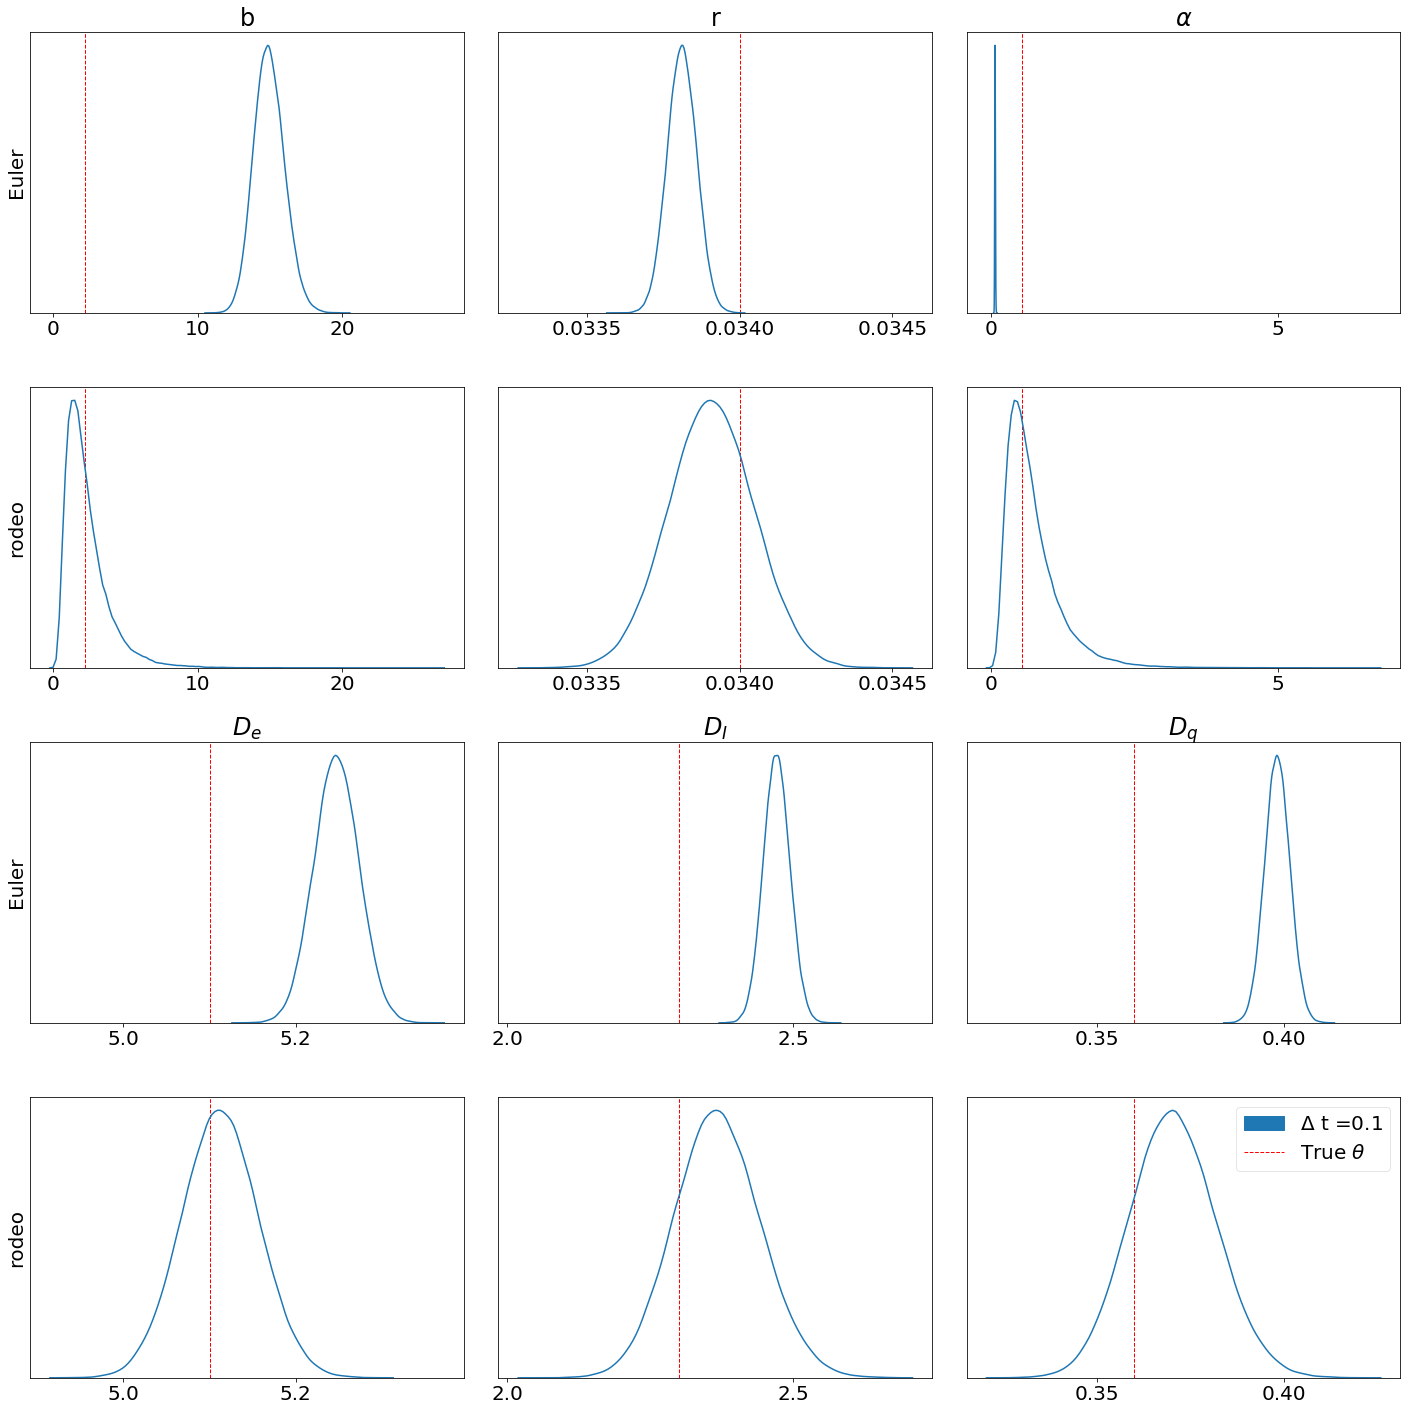

In [7]:
#theta_euler = np.load('saves/seirah_theta_euler3.npy')
#theta_kalman = np.load('saves/seirah_theta_kalman3.npy')
var_names = ["b", "r", r"$\alpha$", "$D_e$", "$D_I$", "$D_q$"]
plt.rcParams.update({'font.size': 20})
clip = [(0, 8), None, (0,2), None, None, None]
figure = inf.theta_plot(theta_euler[:,:,:], theta_kalman[:,:,:], theta_true, hlst, var_names, rows=2)
#figure.savefig('figures/seirahfigure2.pdf')
plt.show()

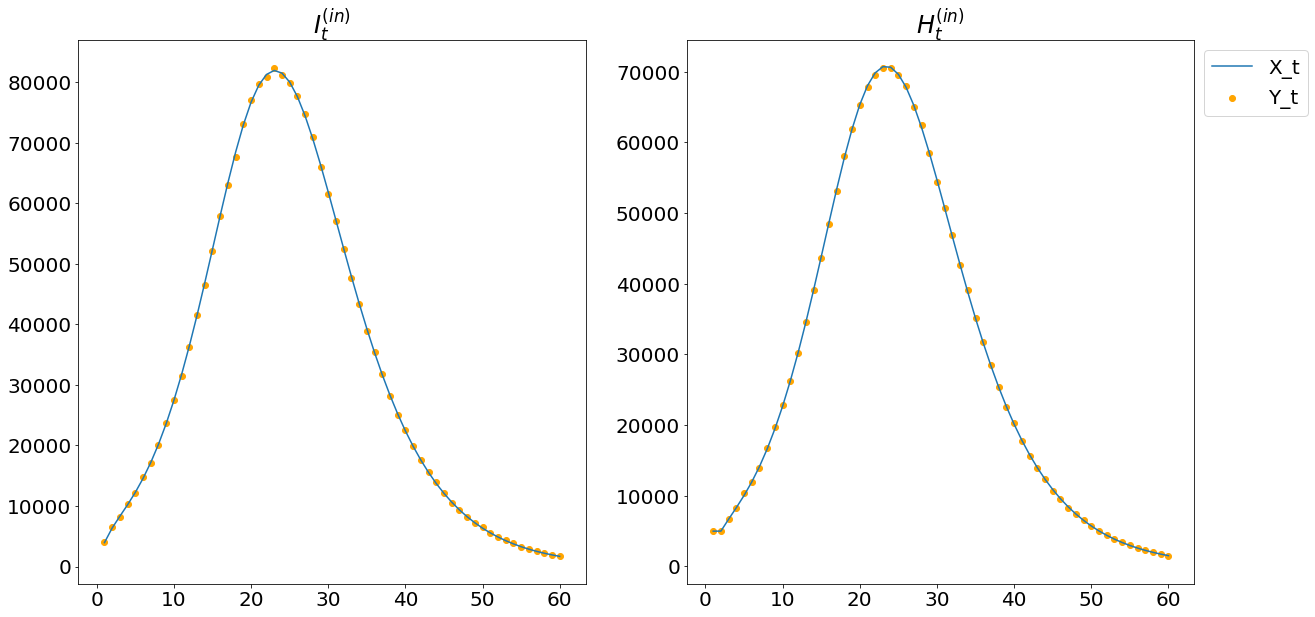

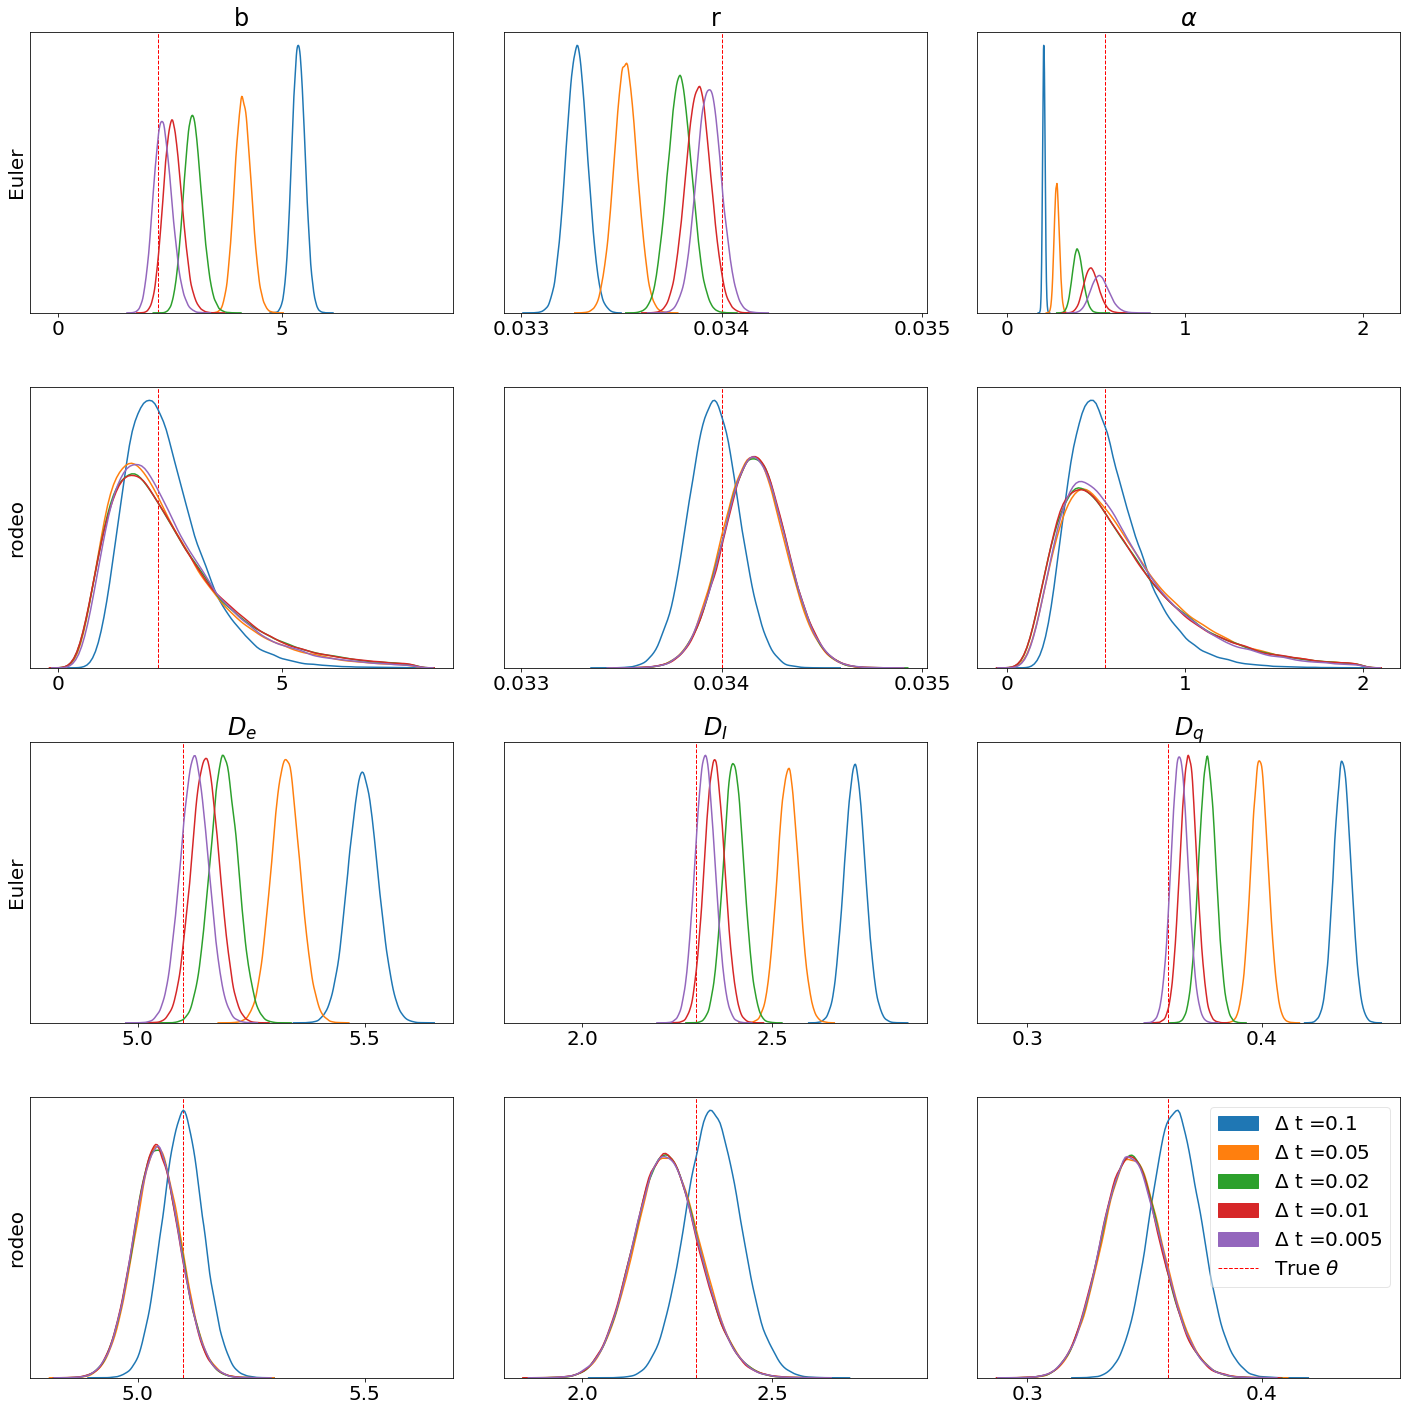

In [11]:
import numpy as np
from inference.covid import covid as inference
import matplotlib.pyplot as plt
from rodeo.ibm import ibm_init
from rodeo.cython.KalmanODE import KalmanODE
from rodeo.utils import indep_init, zero_pad

def seirah(X_t, t, theta, x_out=None):
    "SEIRAH ODE function"
    if x_out is None:
        x_out = np.empty(6)
    p = len(X_t)//6
    S, E, I, R, A, H = X_t[::p]
    N = S + E + I + R + A + H
    b, r, alpha, D_e, D_I, D_q = theta
    D_h = 30
    x_out[0] = -b*S*(I + alpha*A)/N
    x_out[1] = b*S*(I + alpha*A)/N - E/D_e
    x_out[2] = r*E/D_e - I/D_q - I/D_I
    x_out[3] = (I + A)/D_I + H/D_h
    x_out[4] = (1-r)*E/D_e - A/D_I
    x_out[5] = I/D_q - H/D_h
    return x_out

def seirahpad(X_t, t, phi):
    theta = np.exp(phi)
    x_der = np.empty(6)
    p = len(X_t)//6
    S, E, I, R, A, H = X_t[::p]
    N = S + E + I + R + A + H
    b, r, alpha, D_e, D_I, D_q = theta
    D_h = 30
    x_der[0] = -b*S*(I + alpha*A)/N
    x_der[1] = b*S*(I + alpha*A)/N - E/D_e
    x_der[2] = r*E/D_e - I/D_q - I/D_I
    x_der[3] = (I + A)/D_I + H/D_h
    x_der[4] = (1-r)*E/D_e - A/D_I
    x_der[5] = I/D_q - H/D_h
    return np.double(np.ravel([X_t[::p], x_der, np.zeros(6)], "F"))

def seirah_example(load_calcs=False):
    n_deriv = [1]*6 # number of derivatives in IVP
    n_deriv_prior = [3]*6 # number of derivatives in IBM prior
    state_ind = [0, 3, 6, 9, 12, 15] # Index of 0th derivative of each state

    # it is assumed that the solution is sought on the interval [tmin, tmax].
    tmin = 0
    tmax = 60

    # The rest of the parameters can be tuned according to ODE
    # For this problem, we will use
    n_var = 6
    sigma = [.5]*n_var

    # Initial value, x0, for the IVP
    theta_true = np.array([2.23, 0.034, 0.55, 5.1, 2.3, 0.36]) # True theta
    x0 = np.array([63804435, 15492, 21752, 0, 618013, 93583])
    
    # W matrix: dimension is n_eq x sum(n_deriv)
    W_mat = np.zeros((len(n_deriv), sum(n_deriv)+len(n_deriv)))
    for i in range(len(n_deriv)): W_mat[i, sum(n_deriv[:i])+i+1] = 1
    W = zero_pad(W_mat, n_deriv, n_deriv_prior)

    # logprior parameters
    n_theta = len(theta_true)
    phi_mean = np.zeros(n_theta)
    phi_sd = np.log(10)*np.ones(n_theta)

    # Number of samples to draw from posterior
    n_samples = 100000

    # Initialize inference class and simulate observed data
    inf = inference(state_ind, tmin, tmax, seirah)
    inf.funpad = seirahpad
    Y_t, X_t = inf.simulate(seirah, x0, theta_true)

    # Plot observations and true value
    tseq = np.linspace(tmin+1, tmax, tmax-tmin)
    plt.rcParams.update({'font.size': 20})
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    axs[0].plot(tseq,  X_t[:,0], label = 'X_t')
    axs[0].scatter(tseq, Y_t[:,0], label = 'Y_t', color='orange')
    axs[0].set_title("$I^{(in)}_t$")
    axs[1].plot(tseq, X_t[:,1], label = 'X_t')
    axs[1].scatter(tseq, Y_t[:,1], label = 'Y_t', color='orange')
    axs[1].set_title("$H^{(in)}_t$")
    axs[1].legend(loc='upper left', bbox_to_anchor=[1, 1])
    fig.savefig('figures/seirahsim2.pdf')

    hlst = np.array([0.1, 0.05, 0.02, 0.01, 0.005])
    if load_calcs:
        theta_euler = np.load('saves/seirah_theta_euler3.npy')
        theta_kalman = np.load('saves/seirah_theta_kalman2.npy')
    else:
        theta_euler = np.zeros((len(hlst), n_samples, n_theta))
        #theta_euler = np.load('saves/seirah_theta_euler3.npy')
        dt = 1
        phi_init = np.append(np.log(theta_true), np.array([15492, 21752]))
        xx0 = np.array([63804435, None, None, 0, 618013, 93583])
        for i in range(len(hlst)):
            print(hlst[i])
            phi_hat, phi_var = inf.phi_fit(Y_t, xx0, hlst[i], dt, phi_mean, phi_sd, inf.euler_nlpost, 
                                           inf.euler_solve, inf.loglike_pois, phi_init=phi_init)
            theta_euler[i] = inf.theta_sample(phi_hat[:6], phi_var[:6, :6], n_samples)
        np.save('saves/seirah_theta_euler6.npy', theta_euler)
        
        # Parameter inference using Kalman solver
        theta_kalman = np.zeros((len(hlst), n_samples, n_theta))
        #theta_kalman = np.load('saves/seirah_theta_kalman2.npy')
        for i in range(len(hlst)):
            print(hlst[i])
            ode_init= ibm_init(hlst[i], n_deriv_prior, sigma)
            kinit = indep_init(ode_init, n_deriv_prior)
            n_eval = int((tmax-tmin)/hlst[i])
            kode = KalmanODE(W, tmin, tmax, n_eval, seirah, **kinit)
            inf.kode = kode
            inf.W = W
            phi_hat, phi_var = inf.phi_fit(Y_t, xx0, hlst[i], dt, phi_mean, phi_sd, inf.kalman_nlpost, 
                                           inf.kalman_solve, inf.loglike_pois, phi_init=phi_init)
            theta_kalman[i] = inf.theta_sample(phi_hat[:6], phi_var[:6, :6], n_samples)
        np.save('saves/seirah_theta_kalman6.npy', theta_kalman)
    
    plt.rcParams.update({'font.size': 20})
    clip = [(0, 8), None, (0, 2), None, None, None]
    var_names = ["b", "r", r"$\alpha$", "$D_e$", "$D_I$", "$D_q$"]
    figure = inf.theta_plot(theta_euler[:, :, :6], theta_kalman[:, :, :6], theta_true, hlst, var_names, clip=clip, rows=2)
    #figure.savefig('figures/seirahfigure5.pdf')
    plt.show()
    return

if __name__ == '__main__':
    seirah_example(True)


In [12]:
import numpy as np
import numba
from numba import njit, jit
import matplotlib.pyplot as plt
from rodeo.car import car_init
from rodeo.ibm import ibm_init
from rodeo.utils.utils import rand_mat, indep_init, zero_pad
from scipy.integrate import odeint
from rodeo.cython.KalmanODE import KalmanODE as KalmanODE_blas
from rodeo.numba.KalmanODE import KalmanODE as KalmanODE_num
from rodeo.eigen.KalmanODE import KalmanODE
import sys
sys.path.append("..")
from KalmanODE_py import KalmanODE_py
%load_ext Cython


ModuleNotFoundError: No module named 'KalmanODE_py'